# Comparison of Predicting Power of Multiple Advanced Neural Networks for a Univariate Task

Author: Moritz Ahl 

Date: January 2022

Software: Windows 10, Python 3.9, Jupyter Notebook 6.4.5, Tensorflow 2.7.0

In this notebook, the prediction performance of several advanced neural networks will be compared for a univariate financial time series (Apple Stock returns) forecasting task. The model that will be investigated are:

- $\alpha$-RNN,
- LSTM,
- GRU, 
- CNN, and
- CNN with Dilation.

The design of the models is identical to the designs presented in the file Comp_ANN_Final.ipynb.

This code is in parts inspired by the code provided by Dixon et al. on https://github.com/mfrdixon/ML_Finance_Codes/blob/master/Chapter8-Advanced-NNs.

In [1]:
# load standard packages 
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from datetime import timedelta, date
import time 
from tqdm import tqdm
import os

# load statistical packages 
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# load scalers 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# load basic Keras functions for neural networks
import tensorflow.keras.initializers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


# load Yahoo!Finance for download of market data
import yfinance as yf

# note that the directory containing these two .py's must be in the path variable:
from alphaRNN import AlphaRNN
from alphatRNN import AlphatRNN

# to display dataframes
from IPython.display import display

# sound option
import winsound

## Data Import and Preparation 

The data set has been downloaded in advance into an .xlsx file using the plug-in Barchart. It consists of the minutely close price of 100 US stocks and 58 US industry indices over a one year period starting 1 January 2021 and ending 31 December 2021.

In [2]:
# import data to a Pandas dataframe
df = pd.read_excel(open('Market_Data.xlsx', 'rb'), sheet_name='Uni', index_col = 0)
df.head(5)

,AAPL
Date,
2021-12-31 15:59:00,177.5700
2021-12-31 15:58:00,177.6100
2021-12-31 15:57:00,177.5600
2021-12-31 15:56:00,177.5000
2021-12-31 15:55:00,177.5294


In [3]:
# create a copy of data set for further processing 
df_large = df.copy()

Since the data contains NaNs, we will take care of them now by replacing them with the last close price available before.

In [4]:
# find number of NaNs in each time series
for column in df_large.columns:
    print(column,df_large[column].isna().sum())

AAPL 0


In [5]:
# data is listed in descending order -> backfill
df_large = df_large.fillna(method="backfill")

In [6]:
# sort data chronologically 
df_large.sort_values('Date', inplace=True)
df_large.head(5)

,AAPL
Date,
2021-01-04 09:30:00,133.1500
2021-01-04 09:31:00,133.3350
2021-01-04 09:32:00,133.1100
2021-01-04 09:33:00,132.7462
2021-01-04 09:34:00,132.8100


In [7]:
# compute log returns 
df_ret = df_large.copy()

for column in df_ret.columns:
    # extract the close prices and reshape them into 2d-array
    data = np.array(df_ret[column].values)
    data = data.reshape((len(data),1))
    data = data.astype('float32')

    # compute log returns
    z = np.array([0])
    z = z.reshape((1,1))
    ret = np.concatenate((z, np.log(data[1:] / data[:-1])))
    
    # store in dataframe
    df_ret[column] = ret

# drop first row which has return 0 
df_ret.drop(index=df_ret.index[0], axis=0, inplace=True)

As Jan Schmitz argues in a blog post (https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6, accessed 11 January 2022), even very advanced neural networks are incapable of identifying more than a linear trend from standard return data and this would also be the case in this setting since the data set is not big enough. Thus, we will focus on forecasting the 10-time step moving average.

In [8]:
# compute moving average  
df_ret = df_ret.rolling(10).mean()
df_ret.dropna(how='any', axis=0, inplace=True) 
df_ret.head()

,AAPL
Date,
2021-01-04 09:40:00,-0.001075
2021-01-04 09:41:00,-0.000900
2021-01-04 09:42:00,-0.000675
2021-01-04 09:43:00,-0.000427
2021-01-04 09:44:00,-0.000566


In the next step, the moving average returns will be scaled. It is important to scale the data only with regard to what is going to be the training data set, in this case the first 85% of the total data.

In [9]:
# determine end of traning data 
# since data set is very large, 15% is enough
cutoff = int(0.85 * len(df_ret))

# fit scaler to training set 
x = df_ret[:cutoff].values
scaler = MinMaxScaler()
x_scaled = scaler.fit(x)

# scale all data with fitted scaler 
x_scaled_comp = scaler.transform(df_ret.values)

# transform to data frame 
df_scaled = pd.DataFrame(x_scaled_comp, columns=df_ret.columns, index=df_ret.index)
df_scaled.head()

,AAPL
Date,
2021-01-04 09:40:00,0.345590
2021-01-04 09:41:00,0.367773
2021-01-04 09:42:00,0.396382
2021-01-04 09:43:00,0.427727
2021-01-04 09:44:00,0.410117


Next, the data will be prepared for the supervised learning task by generating the input tensors and the labels.

In [10]:
def rolling_windows(df, n_steps=1, n_steps_ahead=1):
    ''' 
    Function to create rolling windows of observations which will be used
    as input data for the neural network. n_steps is the amount of days
    we look back into the past to use previous closing prices, while n_steps_ahead 
    determines the forecasting horizon. df is a dataframe with scaled values.
    '''
    counter = 0 
    for column in tqdm(df.columns):
        counter += 1
        # create empty lists to store data 
        x = []
        y = []

        data = df[column].values    

        # create rolling windows (input) of last n_steps observations
        # and list with current observatiosn (output)
        for i in range(len(data)-(n_steps+n_steps_ahead-1)):
            window = data[i:(i+n_steps)]
            x.append(window)
            y.append(data[i+n_steps+n_steps_ahead-1])

        # transform lists to array for better handling
        x, y = np.array(x), np.array(y)
        x = x.reshape(x.shape[0], x.shape[1], 1)
        y = y.reshape(y.shape[0], 1)
        
        if counter == 1:
            x_total = x
            y_total = y
        else:
            x_total = np.concatenate((x_total,x),axis=2)
            y_total = np.concatenate((y_total,y),axis=1)
    
    return x_total, y_total

In [11]:
# fix length of reference period
n_steps = 30

# prepare supervised data 
# takes a long time to be completed!
x_total1, y_total1 = rolling_windows(df_scaled,n_steps=n_steps)

100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


In [12]:
# print shapes of tensors 
print(x_total1.shape,y_total1.shape)

(98061, 30, 1) (98061, 1)


Split data into training and test data sets.

In [13]:
# split data into training and test sets
x_train, y_train = x_total1[:cutoff,:,:], y_total1[:cutoff,:] 
x_test, y_test = x_total1[cutoff:,:,:], y_total1[cutoff:,:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(83377, 30, 1) (83377, 1) (14684, 30, 1) (14684, 1)


## Plot of Normalized Returns of Apple Stock

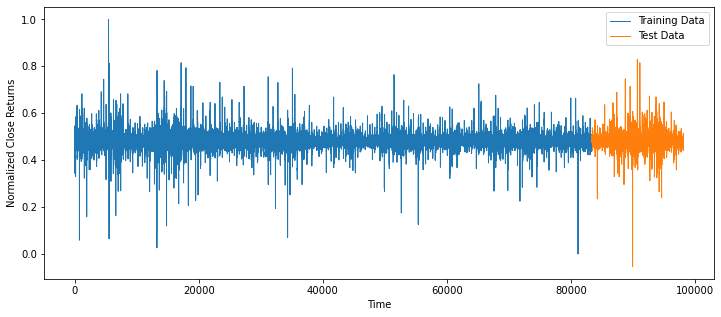

In [14]:
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(0,cutoff), df_scaled['AAPL'][:cutoff], label='Training Data', lw=1)
plt.plot(np.arange(cutoff+1, len(df_scaled)+1), df_scaled['AAPL'][cutoff:], label='Test Data',  lw=1)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Close Returns')
#plt.savefig('C:/Users/morit/Documents/Studium/Master-Arbeit 2021/Master Thesis TeX/figures/AAPL.pdf')
plt.show()

## Creation of Models 

The advanced neural networks will be compared to a deep FFNN which has already proven to outperform other econometrical methods such as ARIMA-GARCH or exponential smoothing. All networks use the same activation function, ReLU, which helps to avoid exploding gradients. Moreover, Dropout ($10\%$) and Initalization is included in the models. Regulariaztion will not be applied since this caused even the most advanced models to produce constant forecasts. The optimizer of choice is the well-studied Adam algorithm and the optimization will take place with regard to the MSE.

The $\alpha$-RNN and $\alpha_t$-RNN layers are the ones coded by Dixon et al. and can be found here: https://github.com/mfrdixon/ML_Finance_Codes/tree/master/Chapter8-Advanced-NNs (accessed 12 January 2022).

In addition, the other models' architecture also builds on the models presented by Dixon et al. but have been extended by more hidden layers and dropout.

The models can now be designed.

In [15]:
# alpha-RNN
def AlphaRNN_(n_units = 50, l1_reg=0, seed=0):
    model = Sequential()
    model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                       bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                       recurrent_initializer=tensorflow.keras.initializers.orthogonal(seed), 
                       kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), 
                       unroll=True))
    model.add(Dropout(0.1))
    model.add(Dense(y_train.shape[1], kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    bias_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# long short-term memory
def LSTM_(n_units = 20, l1_reg=0, seed=0):
    model = Sequential()
    model.add(LSTM(n_units, activation='relu', kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                   bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                   recurrent_initializer=tensorflow.keras.initializers.orthogonal(seed), 
                   kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), 
                   return_sequences=True, unroll=True)) 
    model.add(Dropout(0.1))
    model.add(LSTM(n_units, activation='relu', kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed),
                   bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                   recurrent_initializer=tensorflow.keras.initializers.orthogonal(seed), 
                   kernel_regularizer=l1(l1_reg), return_sequences=True, unroll=True)) 
    model.add(Dropout(0.1))
    model.add(LSTM(n_units, activation='relu', kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                   bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                   recurrent_initializer=tensorflow.keras.initializers.orthogonal(seed), 
                   kernel_regularizer=l1(l1_reg), unroll=True)) 
    model.add(Dropout(0.1))
    model.add(Dense(y_train.shape[1], kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    bias_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
    
# gated recurrent units 
def GRU_(n_units = 20, l1_reg=0, seed=0):
    model = Sequential()
    model.add(GRU(n_units, activation='relu', kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                  bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                  recurrent_initializer=tensorflow.keras.initializers.orthogonal(seed), 
                  kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), 
                  return_sequences=True, unroll=True))  
    model.add(Dropout(0.1))
    model.add(GRU(n_units, activation='relu', kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                  bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                  recurrent_initializer=tensorflow.keras.initializers.orthogonal(seed), 
                  kernel_regularizer=l1(l1_reg), return_sequences=True, unroll=True))  
    model.add(Dropout(0.1))
    model.add(GRU(n_units, activation='relu', kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                  bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                  recurrent_initializer=tensorflow.keras.initializers.orthogonal(seed), 
                  kernel_regularizer=l1(l1_reg), unroll=True))  
    model.add(Dropout(0.1))    
    model.add(Dense(y_train.shape[1], kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    bias_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# convolutional neural network 
def CNN_(n_units = 20, filter_length=5, nb_filter=32, l1_reg=0, seed=0):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu',
                     input_shape=(x_train.shape[1], x_train.shape[-1])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(n_units, activation = 'relu', kernel_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                    bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(0.1))
    model.add(Dense(n_units,  activation = 'relu', kernel_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                    bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(0.1))
    model.add(Dense(y_train.shape[1], kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    bias_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# convolutional neural network with dilation 
def DilCNN_(n_units = 20, filter_length=5, nb_filter=32, l1_reg=0, seed=0):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', 
                     input_shape=(x_train.shape[1], x_train.shape[-1]), dilation_rate=2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(n_units, activation = 'relu', kernel_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                    bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(0.1))
    model.add(Dense(n_units,  activation = 'relu', kernel_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                    bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(0.1))
    model.add(Dense(y_train.shape[1], kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    bias_initializer=tensorflow.keras.initializers.glorot_uniform(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In addition to these well known models, the performance of a Transformer network design should also be evaluated. Since there exists no pre-built implementation of the transformer architecture in Tensorflow and Keras, we will use the architectrure created by Theodoros Ntakouris which can be found here: https://keras.io/examples/timeseries/timeseries_transformer_classification/ (accessed on 12 January 2022). 

Ntakouris' design is an adaption of the original Transformer design for natural language processing and has been modified for time series. While Ntakouris' code is designed to perform classification tasks, we can easily adapt it by removing the activation function and by increasing the number of neurons in the final layer. 

In [16]:
# first build a crucial part of the Transformer: the encoder
# use of layer normalization, dropout and multi-head attention incldued 
# by Theodoros Ntakouris

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # encoder part
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

To enable the network to take the causality / the order of the data into account, we add a Time2Vector layer. The implementation builds on Jan Schmitz' blog post (https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6, accessed on 11 January 2022) and can be found here: https://gist.github.com/JanSchm/b7986ed4809ec768af0a264a162760a8#file-time2vec-py.

In [17]:
# Time2Vector layer by Jan Schmitz
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

In [18]:
# function to build model by Theodoros Ntakouris
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.1,
    mlp_dropout=0.1,
):
    # Time2Vector added to original code 
    time_embedding = Time2Vector(input_shape[0])
    
    inputs = Input(shape=input_shape)
    x = time_embedding(inputs) 
    x = Concatenate(axis=-1)([inputs,x])
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(y_train.shape[1])(x)
    return tensorflow.keras.Model(inputs, outputs)

In [19]:
# function to build model

def Transformer():
    model = build_model(
        input_shape=(x_train.shape[1], x_train.shape[-1]),
        head_size=256,
        num_heads=8,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.1,
        dropout=0.1,
        )
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [20]:
# determine frame for training processes 
max_epochs = 1000
batch_size = 500

# use early stooping w.r.t. validation loss to avoid overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=5e-7, restore_best_weights=True)

## Fitting and Evaluation of Every Model

In [21]:
# define function for training 
def train_model(model, model_name):
    '''This function trains a compiled Keras model and 
    returns the time needed for training.'''    
    
    # show model summary 
    model.summary()
    
    # add checkpointing to save only best model
    string = 'best_model_uni' + str(model_name) +'.h5'
    mc = ModelCheckpoint(string, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    
    # train model 
    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=max_epochs, 
                    batch_size=batch_size, callbacks=[es,mc], shuffle=False,
                    validation_split=0.2, verbose=1)
    end_time = time.time()
    time_needed = round(end_time - start_time, 2)
    
    # load best model adn add custom layers
    model = load_model(string, custom_objects={'AlphaRNN': AlphaRNN, 'AlphatRNN': AlphatRNN, 'Time2Vector': Time2Vector,
                                               'transformer_encoder': transformer_encoder, 
                                               'MultiHeadAttention': MultiHeadAttention})
    
    # make beeps when completed 
    winsound.Beep(400, 1000)
    winsound.Beep(50, 500)
    winsound.Beep(400, 1000)
    winsound.Beep(50, 500)
    winsound.Beep(400, 1000)
    
    print('The training took', time_needed,'seconds.')
    
    return time_needed, history.history['val_loss']

# define function for evaluation 
def pred_eval(model, model_name):
    ''' This function evaluates the predictive power 
    of a previously trained model and returns the 
    RMSEs and maximum erros.'''
    
    # make forecasts
    pred_train = model.predict(x_train, verbose=1)
    pred_test = model.predict(x_test, verbose=1)
    
    # for every column: compute RMSE train and test 
    i = 0
    rmse_train = []
    rmse_test = []
    for column in df_scaled.columns:

        rmse1 = np.sqrt(mean_squared_error(y_train[:,i], pred_train[:,i]))
        rmse2 = np.sqrt(mean_squared_error(y_test[:,i], pred_test[:,i]))

        rmse_train.append(rmse1)
        rmse_test.append(rmse2)

        print('\nResults for', column,':')
        print('Train Error:',rmse1,'Test Error:',rmse2)
        
        # plot forecasts vs. observations for first 10 stocks and indices
        if i <= 9 or (i>=100 and i<=109):
            fig = plt.figure(figsize=(10,6))
            plt.plot(pred_train[:500,i],label='Prediction Training')
            plt.plot(y_train[:500,i],label='Actual Value')
            plt.legend()
            plt.xlabel('Time')
            plt.ylabel('Scaled Return')
            plt.show()

            fig = plt.figure(figsize=(10,6))
            plt.plot(pred_test[:500,i],label='Prediction Test')
            plt.plot(y_test[:500,i],label='Actual Value')
            plt.legend()
            plt.xlabel('Time')
            plt.ylabel('Scaled Return')
            if i == 0: 
                string = 'C:/Users/morit/Documents/Studium/Master-Arbeit 2021/Master Thesis TeX/figures/' + str(model_name) +'_Uni.pdf'
                plt.savefig(string)
            plt.show()
            
        i += 1

    # compute average and max RMSE
    rmse_train = np.array(rmse_train)
    rmse_test = np.array(rmse_test)
    min_test = np.min(rmse_test)
    max_test = np.max(rmse_test)

    avg_rmse_train = np.mean(rmse_train)
    avg_rmse_test = np.mean(rmse_test)

    print('\nAverage Train Error:',avg_rmse_train,'\nAverage Test Error:',avg_rmse_test)
    
    return avg_rmse_train, avg_rmse_test, max_test

## $\alpha$-RNN

In [22]:
# build model 
model_aRNN = AlphaRNN_()

# fit model 
time_needed_aRNN, history_aRNN = train_model(model_aRNN,'aRNN')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 alpha_rnn (AlphaRNN)        (None, 50)                2601      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
133/134 [============================>.] - ETA: 0s - loss: 0.0097
Epoch 00001: val_loss improved from inf to 0.00062, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 12s 36ms/step - loss: 0.0097 - val_loss: 6.2070e-04
Epoch 2/1000
132/134 [============================>.] 

Epoch 29/1000
134/134 [==============================] - ETA: 0s - loss: 2.2831e-04
Epoch 00029: val_loss did not improve from 0.00014
134/134 [==============================] - 3s 25ms/step - loss: 2.2831e-04 - val_loss: 1.4442e-04
Epoch 30/1000
134/134 [==============================] - ETA: 0s - loss: 2.2563e-04- ETA: 0s - loss: 2.4
Epoch 00030: val_loss improved from 0.00014 to 0.00014, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 3s 25ms/step - loss: 2.2563e-04 - val_loss: 1.4149e-04
Epoch 31/1000
133/134 [============================>.] - ETA: 0s - loss: 2.2501e-04
Epoch 00031: val_loss improved from 0.00014 to 0.00014, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 3s 26ms/step - loss: 2.2466e-04 - val_loss: 1.3951e-04
Epoch 32/1000
133/134 [============================>.] - ETA: 0s - loss: 2.2289e-04- ETA: 0s - loss: 2.365
Epoch 00032: val_loss did not improve from 0.00014
134/134 [===========================

134/134 [==============================] - ETA: 0s - loss: 2.0348e-04
Epoch 00062: val_loss did not improve from 0.00014
134/134 [==============================] - 4s 30ms/step - loss: 2.0348e-04 - val_loss: 1.3749e-04
Epoch 63/1000
133/134 [============================>.] - ETA: 0s - loss: 2.0230e-04
Epoch 00063: val_loss improved from 0.00014 to 0.00014, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 32ms/step - loss: 2.0198e-04 - val_loss: 1.3695e-04
Epoch 64/1000
133/134 [============================>.] - ETA: 0s - loss: 2.0174e-04
Epoch 00064: val_loss did not improve from 0.00014
134/134 [==============================] - 4s 30ms/step - loss: 2.0142e-04 - val_loss: 1.3851e-04
Epoch 65/1000
134/134 [==============================] - ETA: 0s - loss: 2.0050e-04
Epoch 00065: val_loss improved from 0.00014 to 0.00014, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 29ms/step - loss: 2.0050e-04 - val_loss: 1.3501e

Epoch 94/1000
132/134 [============================>.] - ETA: 0s - loss: 1.7900e-04
Epoch 00094: val_loss improved from 0.00012 to 0.00012, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 29ms/step - loss: 1.7775e-04 - val_loss: 1.2200e-04
Epoch 95/1000
132/134 [============================>.] - ETA: 0s - loss: 1.7868e-04
Epoch 00095: val_loss did not improve from 0.00012
134/134 [==============================] - 4s 30ms/step - loss: 1.7744e-04 - val_loss: 1.2258e-04
Epoch 96/1000
132/134 [============================>.] - ETA: 0s - loss: 1.7758e-04
Epoch 00096: val_loss did not improve from 0.00012
134/134 [==============================] - 4s 32ms/step - loss: 1.7635e-04 - val_loss: 1.2258e-04
Epoch 97/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7668e-04
Epoch 00097: val_loss improved from 0.00012 to 0.00012, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 32ms/step - loss: 1.7639e-04 - val

132/134 [============================>.] - ETA: 0s - loss: 1.7689e-04
Epoch 00126: val_loss did not improve from 0.00012
134/134 [==============================] - 5s 39ms/step - loss: 1.7568e-04 - val_loss: 1.1662e-04
Epoch 127/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7415e-04
Epoch 00127: val_loss did not improve from 0.00012
134/134 [==============================] - 4s 33ms/step - loss: 1.7386e-04 - val_loss: 1.1652e-04
Epoch 128/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7488e-04
Epoch 00128: val_loss improved from 0.00012 to 0.00012, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 5s 34ms/step - loss: 1.7459e-04 - val_loss: 1.1649e-04
Epoch 129/1000
132/134 [============================>.] - ETA: 0s - loss: 1.7515e-04
Epoch 00129: val_loss improved from 0.00012 to 0.00012, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 32ms/step - loss: 1.7394e-04 - val_loss: 1.16

Epoch 159/1000
134/134 [==============================] - ETA: 0s - loss: 1.6927e-04
Epoch 00159: val_loss improved from 0.00011 to 0.00011, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 31ms/step - loss: 1.6927e-04 - val_loss: 1.1398e-04
Epoch 160/1000
133/134 [============================>.] - ETA: 0s - loss: 1.6899e-04
Epoch 00160: val_loss improved from 0.00011 to 0.00011, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 28ms/step - loss: 1.6870e-04 - val_loss: 1.1334e-04
Epoch 161/1000
132/134 [============================>.] - ETA: 0s - loss: 1.6989e-04
Epoch 00161: val_loss improved from 0.00011 to 0.00011, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 3s 22ms/step - loss: 1.6872e-04 - val_loss: 1.1279e-04
Epoch 162/1000
133/134 [============================>.] - ETA: 0s - loss: 1.6881e-04
Epoch 00162: val_loss did not improve from 0.00011
134/134 [========================

Epoch 191/1000
132/134 [============================>.] - ETA: 0s - loss: 1.5786e-04
Epoch 00191: val_loss did not improve from 0.00011
134/134 [==============================] - 4s 31ms/step - loss: 1.5677e-04 - val_loss: 1.0640e-04
Epoch 192/1000
133/134 [============================>.] - ETA: 0s - loss: 1.5647e-04
Epoch 00192: val_loss did not improve from 0.00011
134/134 [==============================] - 4s 32ms/step - loss: 1.5619e-04 - val_loss: 1.0630e-04
Epoch 193/1000
133/134 [============================>.] - ETA: 0s - loss: 1.5714e-04
Epoch 00193: val_loss did not improve from 0.00011
134/134 [==============================] - 4s 30ms/step - loss: 1.5688e-04 - val_loss: 1.0628e-04
Epoch 194/1000
133/134 [============================>.] - ETA: 0s - loss: 1.5775e-04
Epoch 00194: val_loss did not improve from 0.00011
134/134 [==============================] - 4s 29ms/step - loss: 1.5748e-04 - val_loss: 1.0616e-04
Epoch 195/1000
133/134 [============================>.] - ETA: 0

Epoch 225/1000
133/134 [============================>.] - ETA: 0s - loss: 1.5526e-04
Epoch 00225: val_loss improved from 0.00011 to 0.00011, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 30ms/step - loss: 1.5500e-04 - val_loss: 1.0518e-04
Epoch 226/1000
132/134 [============================>.] - ETA: 0s - loss: 1.5702e-04- ETA: 0s - loss: 1.662
Epoch 00226: val_loss did not improve from 0.00011
134/134 [==============================] - 4s 26ms/step - loss: 1.5593e-04 - val_loss: 1.0564e-04
Epoch 227/1000
132/134 [============================>.] - ETA: 0s - loss: 1.5701e-04
Epoch 00227: val_loss did not improve from 0.00011
134/134 [==============================] - 4s 29ms/step - loss: 1.5591e-04 - val_loss: 1.0521e-04
Epoch 228/1000
133/134 [============================>.] - ETA: 0s - loss: 1.5622e-04- ETA: 0s - loss: 1.5776e-0
Epoch 00228: val_loss did not improve from 0.00011
134/134 [==============================] - 4s 31ms/step - loss: 1.559

Epoch 258/1000
132/134 [============================>.] - ETA: 0s - loss: 1.5529e-04
Epoch 00258: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 32ms/step - loss: 1.5419e-04 - val_loss: 1.0432e-04
Epoch 259/1000
132/134 [============================>.] - ETA: 0s - loss: 1.5583e-04
Epoch 00259: val_loss improved from 0.00010 to 0.00010, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 27ms/step - loss: 1.5475e-04 - val_loss: 1.0421e-04
Epoch 260/1000
134/134 [==============================] - ETA: 0s - loss: 1.5487e-04
Epoch 00260: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 29ms/step - loss: 1.5487e-04 - val_loss: 1.0428e-04
Epoch 261/1000
133/134 [============================>.] - ETA: 0s - loss: 1.5507e-04
Epoch 00261: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 31ms/step - loss: 1.5481e-04 - val_loss: 1.0426e-04
Epoch 262/1000
133/13

Epoch 291/1000
132/134 [============================>.] - ETA: 0s - loss: 1.4649e-04
Epoch 00291: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 31ms/step - loss: 1.4543e-04 - val_loss: 9.9159e-05
Epoch 292/1000
133/134 [============================>.] - ETA: 0s - loss: 1.4637e-04
Epoch 00292: val_loss improved from 0.00010 to 0.00010, saving model to best_model_uniaRNN.h5
134/134 [==============================] - 4s 32ms/step - loss: 1.4611e-04 - val_loss: 9.9009e-05
Epoch 293/1000
132/134 [============================>.] - ETA: 0s - loss: 1.4723e-04
Epoch 00293: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 28ms/step - loss: 1.4617e-04 - val_loss: 9.9182e-05
Epoch 294/1000
132/134 [============================>.] - ETA: 0s - loss: 1.4737e-04
Epoch 00294: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 31ms/step - loss: 1.4631e-04 - val_loss: 9.9135e-05
Epoch 295/1000
132/13

132/134 [============================>.] - ETA: 0s - loss: 1.4702e-04
Epoch 00325: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 26ms/step - loss: 1.4597e-04 - val_loss: 9.8970e-05
Epoch 326/1000
133/134 [============================>.] - ETA: 0s - loss: 1.4536e-04
Epoch 00326: val_loss did not improve from 0.00010
134/134 [==============================] - 3s 25ms/step - loss: 1.4509e-04 - val_loss: 9.9120e-05
Epoch 327/1000
132/134 [============================>.] - ETA: 0s - loss: 1.4651e-04
Epoch 00327: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 30ms/step - loss: 1.4546e-04 - val_loss: 9.9014e-05
Epoch 328/1000
132/134 [============================>.] - ETA: 0s - loss: 1.4639e-04
Epoch 00328: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 32ms/step - loss: 1.4534e-04 - val_loss: 9.8963e-05
Epoch 329/1000
133/134 [============================>.] - ETA: 0s - loss: 1.458

Epoch 360/1000
133/134 [============================>.] - ETA: 0s - loss: 1.4631e-04
Epoch 00360: val_loss did not improve from 0.00010
134/134 [==============================] - 3s 25ms/step - loss: 1.4605e-04 - val_loss: 9.8892e-05
Epoch 361/1000
133/134 [============================>.] - ETA: 0s - loss: 1.4561e-04
Epoch 00361: val_loss did not improve from 0.00010
134/134 [==============================] - 3s 24ms/step - loss: 1.4536e-04 - val_loss: 9.9056e-05
Epoch 362/1000
132/134 [============================>.] - ETA: 0s - loss: 1.4745e-04
Epoch 00362: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 30ms/step - loss: 1.4639e-04 - val_loss: 9.8911e-05
Epoch 363/1000
134/134 [==============================] - ETA: 0s - loss: 1.4572e-04
Epoch 00363: val_loss did not improve from 0.00010
134/134 [==============================] - 4s 31ms/step - loss: 1.4572e-04 - val_loss: 9.8937e-05
Epoch 364/1000
133/134 [============================>.] - ETA: 0

459/459 [==============================] - 1s 3ms/step

Results for AAPL :
Train Error: 0.011479108848744052 Test Error: 0.013451185242657355


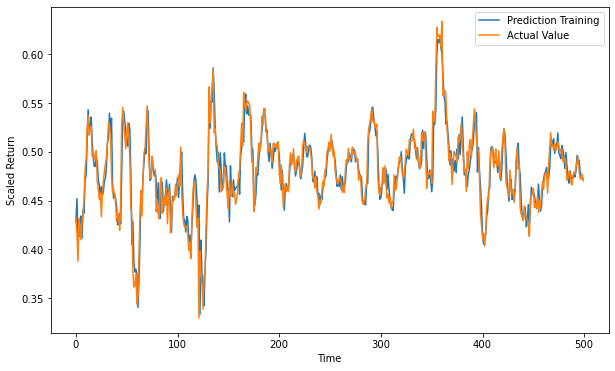

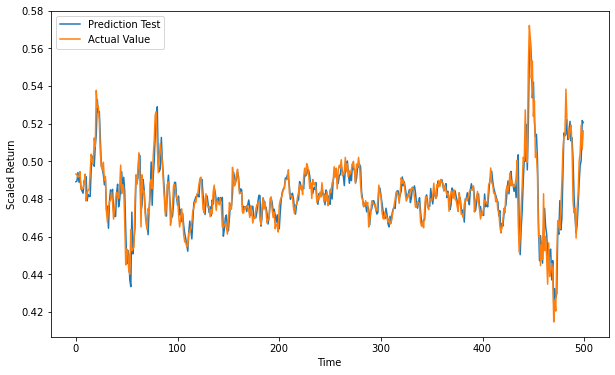


Average Train Error: 0.011479108848744052 
Average Test Error: 0.013451185242657355


In [23]:
# make predictions and evaluate model 
rmse_train_aRNN, rmse_test_aRNN, rmse_max_aRNN = pred_eval(model_aRNN, 'aRNN')

In [25]:
# manually check for number of parameters and epochs needed 
no_params_aRNN = 2652
epochs_aRNN = 376 #manually 

# display results 
aRNN_results = np.array(['{:}'.format(no_params_aRNN), '{:}'.format(epochs_aRNN), round(time_needed_aRNN/60,2), 
                        '{:.3e}'.format(rmse_train_aRNN), '{:.3e}'.format(rmse_test_aRNN)])
aRNN_results = aRNN_results.reshape((1,5))
table_aRNN = pd.DataFrame(aRNN_results,index=['Alpha RNN'],
                         columns=['No. Parameters','No. Epochs','Time [m]','RMSE Train','RMSE Test'])
table_aRNN

,No. Parameters,No. Epochs,Time [m],RMSE Train,RMSE Test
Alpha RNN,2652,376,24.89,1.148e-02,1.345e-02


## LSTM

In [26]:
# build model 
model_LSTM = LSTM_()

# fit model 
time_needed_LSTM, history_LSTM = train_model(model_LSTM,'LSTM')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 20)            1760      
                                                                 
 dropout_1 (Dropout)         (None, 30, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 20)            3280      
                                                                 
 dropout_2 (Dropout)         (None, 30, 20)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

Epoch 30/1000
134/134 [==============================] - ETA: 0s - loss: 0.0093
Epoch 00030: val_loss did not improve from 0.00101
134/134 [==============================] - 15s 115ms/step - loss: 0.0093 - val_loss: 0.0010
Epoch 31/1000
133/134 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 00031: val_loss did not improve from 0.00101
134/134 [==============================] - 16s 116ms/step - loss: 0.0083 - val_loss: 0.0010
Epoch 32/1000
133/134 [============================>.] - ETA: 0s - loss: 0.0075
Epoch 00032: val_loss improved from 0.00101 to 0.00097, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 15s 114ms/step - loss: 0.0075 - val_loss: 9.6505e-04
Epoch 33/1000
133/134 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 00033: val_loss improved from 0.00097 to 0.00089, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 15s 113ms/step - loss: 0.0067 - val_loss: 8.8562e-04
Epoch 34/1000


133/134 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00061: val_loss improved from 0.00072 to 0.00072, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 16s 118ms/step - loss: 0.0011 - val_loss: 7.2050e-04
Epoch 62/1000
133/134 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00062: val_loss improved from 0.00072 to 0.00072, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 16s 118ms/step - loss: 0.0011 - val_loss: 7.1813e-04
Epoch 63/1000
133/134 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00063: val_loss improved from 0.00072 to 0.00071, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 14s 105ms/step - loss: 0.0011 - val_loss: 7.1183e-04
Epoch 64/1000
133/134 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00064: val_loss improved from 0.00071 to 0.00071, saving model to best_model_uniLSTM.h5
134/134 [=====================

Epoch 92/1000
134/134 [==============================] - ETA: 0s - loss: 5.1453e-04
Epoch 00092: val_loss did not improve from 0.00047
134/134 [==============================] - 19s 138ms/step - loss: 5.1453e-04 - val_loss: 4.7676e-04
Epoch 93/1000
134/134 [==============================] - ETA: 0s - loss: 5.1222e-04
Epoch 00093: val_loss did not improve from 0.00047
134/134 [==============================] - 21s 159ms/step - loss: 5.1222e-04 - val_loss: 4.9080e-04
Epoch 94/1000
133/134 [============================>.] - ETA: 0s - loss: 4.9334e-04
Epoch 00094: val_loss improved from 0.00047 to 0.00046, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 15s 110ms/step - loss: 4.9245e-04 - val_loss: 4.6255e-04
Epoch 95/1000
133/134 [============================>.] - ETA: 0s - loss: 4.8480e-04
Epoch 00095: val_loss improved from 0.00046 to 0.00046, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 17s 128ms/step - loss: 4.8395e-

Epoch 125/1000
133/134 [============================>.] - ETA: 0s - loss: 3.0226e-04
Epoch 00125: val_loss did not improve from 0.00040
134/134 [==============================] - 16s 117ms/step - loss: 3.0178e-04 - val_loss: 4.0743e-04
Epoch 126/1000
133/134 [============================>.] - ETA: 0s - loss: 2.9537e-04
Epoch 00126: val_loss did not improve from 0.00040
134/134 [==============================] - 14s 106ms/step - loss: 2.9484e-04 - val_loss: 4.0950e-04
Epoch 127/1000
133/134 [============================>.] - ETA: 0s - loss: 2.9231e-04
Epoch 00127: val_loss improved from 0.00040 to 0.00039, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 15s 115ms/step - loss: 2.9181e-04 - val_loss: 3.8652e-04
Epoch 128/1000
133/134 [============================>.] - ETA: 0s - loss: 2.9273e-04
Epoch 00128: val_loss improved from 0.00039 to 0.00038, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 15s 110ms/step - loss: 2.92

Epoch 159/1000
133/134 [============================>.] - ETA: 0s - loss: 2.5893e-04
Epoch 00159: val_loss did not improve from 0.00036
134/134 [==============================] - 15s 111ms/step - loss: 2.5856e-04 - val_loss: 3.7043e-04
Epoch 160/1000
133/134 [============================>.] - ETA: 0s - loss: 2.6158e-04
Epoch 00160: val_loss did not improve from 0.00036
134/134 [==============================] - 15s 111ms/step - loss: 2.6118e-04 - val_loss: 3.6753e-04
Epoch 161/1000
134/134 [==============================] - ETA: 0s - loss: 2.5713e-04
Epoch 00161: val_loss did not improve from 0.00036
134/134 [==============================] - 18s 135ms/step - loss: 2.5713e-04 - val_loss: 3.6932e-04
Epoch 162/1000
133/134 [============================>.] - ETA: 0s - loss: 2.5378e-04
Epoch 00162: val_loss did not improve from 0.00036
134/134 [==============================] - 17s 128ms/step - loss: 2.5338e-04 - val_loss: 3.6505e-04
Epoch 163/1000
133/134 [============================>.] 

133/134 [============================>.] - ETA: 0s - loss: 2.3640e-04- ETA: 0s - loss: 2.3935
Epoch 00193: val_loss did not improve from 0.00035
134/134 [==============================] - 14s 102ms/step - loss: 2.3602e-04 - val_loss: 3.7469e-04
Epoch 194/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3264e-04
Epoch 00194: val_loss did not improve from 0.00035
134/134 [==============================] - 14s 102ms/step - loss: 2.3227e-04 - val_loss: 3.7674e-04
Epoch 195/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3366e-04
Epoch 00195: val_loss did not improve from 0.00035
134/134 [==============================] - 13s 100ms/step - loss: 2.3333e-04 - val_loss: 3.8621e-04
Epoch 196/1000
134/134 [==============================] - ETA: 0s - loss: 2.3427e-04
Epoch 00196: val_loss did not improve from 0.00035
134/134 [==============================] - 16s 118ms/step - loss: 2.3427e-04 - val_loss: 3.6772e-04
Epoch 197/1000
133/134 [=======================

Epoch 227/1000
133/134 [============================>.] - ETA: 0s - loss: 2.1215e-04
Epoch 00227: val_loss did not improve from 0.00032
134/134 [==============================] - 14s 107ms/step - loss: 2.1178e-04 - val_loss: 3.4294e-04
Epoch 228/1000
133/134 [============================>.] - ETA: 0s - loss: 2.1582e-04
Epoch 00228: val_loss did not improve from 0.00032
134/134 [==============================] - 15s 114ms/step - loss: 2.1547e-04 - val_loss: 3.3993e-04
Epoch 229/1000
133/134 [============================>.] - ETA: 0s - loss: 2.1585e-04
Epoch 00229: val_loss did not improve from 0.00032
134/134 [==============================] - 14s 106ms/step - loss: 2.1551e-04 - val_loss: 3.3817e-04
Epoch 230/1000
133/134 [============================>.] - ETA: 0s - loss: 2.1276e-04
Epoch 00230: val_loss did not improve from 0.00032
134/134 [==============================] - 15s 112ms/step - loss: 2.1243e-04 - val_loss: 3.2914e-04
Epoch 231/1000
133/134 [============================>.] 

133/134 [============================>.] - ETA: 0s - loss: 1.9719e-04
Epoch 00261: val_loss did not improve from 0.00030
134/134 [==============================] - 15s 112ms/step - loss: 1.9688e-04 - val_loss: 3.2125e-04
Epoch 262/1000
133/134 [============================>.] - ETA: 0s - loss: 1.9718e-04
Epoch 00262: val_loss did not improve from 0.00030
134/134 [==============================] - 14s 106ms/step - loss: 1.9686e-04 - val_loss: 3.0483e-04
Epoch 263/1000
134/134 [==============================] - ETA: 0s - loss: 1.9641e-04- ETA: 0s - loss: 1.9770e-
Epoch 00263: val_loss did not improve from 0.00030
134/134 [==============================] - 14s 105ms/step - loss: 1.9641e-04 - val_loss: 3.1383e-04
Epoch 264/1000
133/134 [============================>.] - ETA: 0s - loss: 2.0526e-04
Epoch 00264: val_loss did not improve from 0.00030
134/134 [==============================] - 14s 105ms/step - loss: 2.0490e-04 - val_loss: 3.3648e-04
Epoch 265/1000
133/134 [=====================

133/134 [============================>.] - ETA: 0s - loss: 1.9515e-04
Epoch 00295: val_loss did not improve from 0.00028
134/134 [==============================] - 15s 111ms/step - loss: 1.9480e-04 - val_loss: 3.0720e-04
Epoch 296/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8668e-04
Epoch 00296: val_loss did not improve from 0.00028
134/134 [==============================] - 14s 107ms/step - loss: 1.8635e-04 - val_loss: 3.1360e-04
Epoch 297/1000
134/134 [==============================] - ETA: 0s - loss: 1.8987e-04
Epoch 00297: val_loss did not improve from 0.00028
134/134 [==============================] - 15s 116ms/step - loss: 1.8987e-04 - val_loss: 3.0061e-04
Epoch 298/1000
133/134 [============================>.] - ETA: 0s - loss: 1.9628e-04
Epoch 00298: val_loss did not improve from 0.00028
134/134 [==============================] - 15s 109ms/step - loss: 1.9594e-04 - val_loss: 3.1859e-04
Epoch 299/1000
133/134 [============================>.] - ETA: 0s - los

134/134 [==============================] - ETA: 0s - loss: 1.8852e-04
Epoch 00329: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 108ms/step - loss: 1.8852e-04 - val_loss: 2.7730e-04
Epoch 330/1000
133/134 [============================>.] - ETA: 0s - loss: 1.9542e-04
Epoch 00330: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 104ms/step - loss: 1.9510e-04 - val_loss: 2.9553e-04
Epoch 331/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8358e-04
Epoch 00331: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 105ms/step - loss: 1.8325e-04 - val_loss: 3.0431e-04
Epoch 332/1000
133/134 [============================>.] - ETA: 0s - loss: 1.9111e-04
Epoch 00332: val_loss did not improve from 0.00026
134/134 [==============================] - 15s 112ms/step - loss: 1.9075e-04 - val_loss: 2.9752e-04
Epoch 333/1000
133/134 [============================>.] - ETA: 0s - los

Epoch 364/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8532e-04
Epoch 00364: val_loss did not improve from 0.00026
134/134 [==============================] - 13s 101ms/step - loss: 1.8501e-04 - val_loss: 3.2777e-04
Epoch 365/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8663e-04
Epoch 00365: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 103ms/step - loss: 1.8633e-04 - val_loss: 2.9407e-04
Epoch 366/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8366e-04
Epoch 00366: val_loss did not improve from 0.00026
134/134 [==============================] - 13s 101ms/step - loss: 1.8334e-04 - val_loss: 2.8501e-04
Epoch 367/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8943e-04
Epoch 00367: val_loss did not improve from 0.00026
134/134 [==============================] - 13s 101ms/step - loss: 1.8907e-04 - val_loss: 2.9553e-04
Epoch 368/1000
133/134 [============================>.] 

133/134 [============================>.] - ETA: 0s - loss: 1.8687e-04
Epoch 00398: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 107ms/step - loss: 1.8655e-04 - val_loss: 3.1670e-04
Epoch 399/1000
134/134 [==============================] - ETA: 0s - loss: 1.8167e-04
Epoch 00399: val_loss did not improve from 0.00026
134/134 [==============================] - 18s 137ms/step - loss: 1.8167e-04 - val_loss: 2.9281e-04
Epoch 400/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7823e-04
Epoch 00400: val_loss did not improve from 0.00026
134/134 [==============================] - 17s 129ms/step - loss: 1.7793e-04 - val_loss: 2.9183e-04
Epoch 401/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8367e-04
Epoch 00401: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 105ms/step - loss: 1.8335e-04 - val_loss: 2.6767e-04
Epoch 402/1000
133/134 [============================>.] - ETA: 0s - los

Epoch 433/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7998e-04
Epoch 00433: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 106ms/step - loss: 1.7968e-04 - val_loss: 3.1262e-04
Epoch 434/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7698e-04
Epoch 00434: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 104ms/step - loss: 1.7666e-04 - val_loss: 3.0329e-04
Epoch 435/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8103e-04
Epoch 00435: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 108ms/step - loss: 1.8070e-04 - val_loss: 2.8874e-04
Epoch 436/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7737e-04
Epoch 00436: val_loss did not improve from 0.00026
134/134 [==============================] - 14s 104ms/step - loss: 1.7706e-04 - val_loss: 2.8234e-04
Epoch 437/1000
133/134 [============================>.] 

Epoch 468/1000
134/134 [==============================] - ETA: 0s - loss: 1.8044e-04
Epoch 00468: val_loss did not improve from 0.00025
134/134 [==============================] - 17s 125ms/step - loss: 1.8044e-04 - val_loss: 3.0148e-04
Epoch 469/1000
134/134 [==============================] - ETA: 0s - loss: 1.7708e-04
Epoch 00469: val_loss did not improve from 0.00025
134/134 [==============================] - 19s 139ms/step - loss: 1.7708e-04 - val_loss: 3.0606e-04
Epoch 470/1000
134/134 [==============================] - ETA: 0s - loss: 1.7515e-04
Epoch 00470: val_loss did not improve from 0.00025
134/134 [==============================] - 18s 134ms/step - loss: 1.7515e-04 - val_loss: 3.0542e-04
Epoch 471/1000
134/134 [==============================] - ETA: 0s - loss: 1.9054e-04
Epoch 00471: val_loss did not improve from 0.00025
134/134 [==============================] - 18s 131ms/step - loss: 1.9054e-04 - val_loss: 3.0158e-04
Epoch 472/1000
133/134 [============================>.] 

134/134 [==============================] - ETA: 0s - loss: 1.7221e-04- 
Epoch 00502: val_loss improved from 0.00025 to 0.00024, saving model to best_model_uniLSTM.h5
134/134 [==============================] - 14s 105ms/step - loss: 1.7221e-04 - val_loss: 2.3770e-04
Epoch 503/1000
134/134 [==============================] - ETA: 0s - loss: 1.7545e-04
Epoch 00503: val_loss did not improve from 0.00024
134/134 [==============================] - 14s 107ms/step - loss: 1.7545e-04 - val_loss: 2.8761e-04
Epoch 504/1000
134/134 [==============================] - ETA: 0s - loss: 1.7456e-04
Epoch 00504: val_loss did not improve from 0.00024
134/134 [==============================] - 14s 103ms/step - loss: 1.7456e-04 - val_loss: 2.7825e-04
Epoch 505/1000
134/134 [==============================] - ETA: 0s - loss: 1.7392e-04
Epoch 00505: val_loss did not improve from 0.00024
134/134 [==============================] - 14s 104ms/step - loss: 1.7392e-04 - val_loss: 2.8556e-04
Epoch 506/1000
134/134 [==

133/134 [============================>.] - ETA: 0s - loss: 1.7732e-04-  - ETA: 0s - loss: 1.7819e-0
Epoch 00536: val_loss did not improve from 0.00024
134/134 [==============================] - 14s 104ms/step - loss: 1.7706e-04 - val_loss: 3.0121e-04
Epoch 537/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8053e-04
Epoch 00537: val_loss did not improve from 0.00024
134/134 [==============================] - 14s 103ms/step - loss: 1.8019e-04 - val_loss: 2.8967e-04
Epoch 538/1000
134/134 [==============================] - ETA: 0s - loss: 1.7458e-04
Epoch 00538: val_loss did not improve from 0.00024
134/134 [==============================] - 14s 102ms/step - loss: 1.7458e-04 - val_loss: 2.7879e-04
Epoch 539/1000
134/134 [==============================] - ETA: 0s - loss: 1.7446e-04
Epoch 00539: val_loss did not improve from 0.00024
134/134 [==============================] - 14s 102ms/step - loss: 1.7446e-04 - val_loss: 2.8382e-04
Epoch 540/1000
133/134 [=================

Epoch 571/1000
134/134 [==============================] - ETA: 0s - loss: 1.7363e-04
Epoch 00571: val_loss did not improve from 0.00024
134/134 [==============================] - 14s 102ms/step - loss: 1.7363e-04 - val_loss: 2.9879e-04
Epoch 572/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7026e-04- ETA: 0s - loss: 1.
Epoch 00572: val_loss did not improve from 0.00024
134/134 [==============================] - 15s 114ms/step - loss: 1.6994e-04 - val_loss: 2.6464e-04
Epoch 573/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7666e-04
Epoch 00573: val_loss did not improve from 0.00024
134/134 [==============================] - 15s 109ms/step - loss: 1.7638e-04 - val_loss: 3.0191e-04
Epoch 574/1000
133/134 [============================>.] - ETA: 0s - loss: 1.7373e-04
Epoch 00574: val_loss did not improve from 0.00024
134/134 [==============================] - 15s 112ms/step - loss: 1.7342e-04 - val_loss: 2.7025e-04
Epoch 575/1000
134/134 [============

459/459 [==============================] - 3s 6ms/step

Results for AAPL :
Train Error: 0.017443030632672604 Test Error: 0.020237015048259942


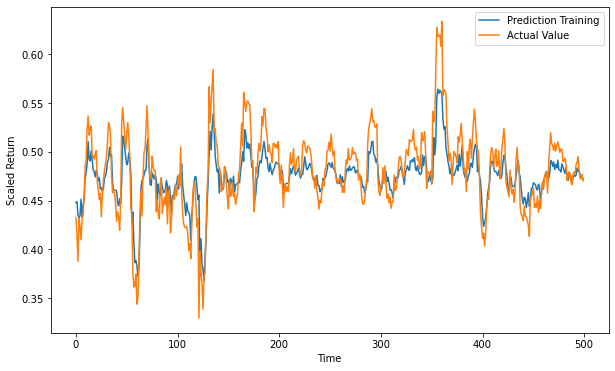

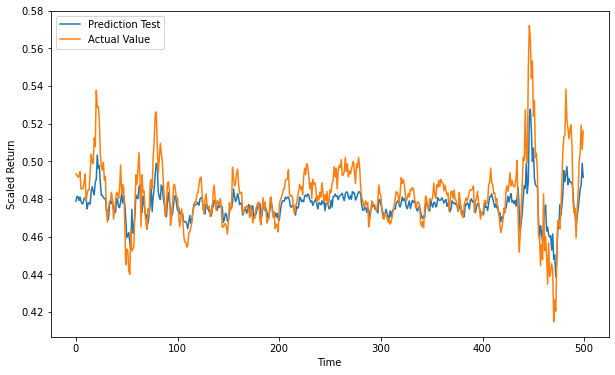


Average Train Error: 0.017443030632672604 
Average Test Error: 0.020237015048259942


In [27]:
# make predictions and evaluate model 
rmse_train_LSTM, rmse_test_LSTM, rmse_max_LSTM = pred_eval(model_LSTM, 'LSTM')

In [29]:
# manually check for number of parameters and epochs needed 
no_params_LSTM = 8341
epochs_LSTM = 602 #manually 

# display results 
LSTM_results = np.array(['{:}'.format(no_params_LSTM), '{:}'.format(epochs_LSTM), round(time_needed_LSTM/60,2), 
                        '{:.3e}'.format(rmse_train_LSTM), '{:.3e}'.format(rmse_test_LSTM)])
LSTM_results = LSTM_results.reshape((1,5))
table_LSTM = pd.DataFrame(LSTM_results,index=['LSTM'],
                         columns=['No. Parameters','No. Epochs','Time [m]','RMSE Train','RMSE Test'])
table_LSTM

,No. Parameters,No. Epochs,Time [m],RMSE Train,RMSE Test
LSTM,8341,602,149.81,1.744e-02,2.024e-02


## GRU

In [30]:
# build model 
model_GRU = GRU_()

# fit model 
time_needed_GRU, history_GRU = train_model(model_GRU,'GRU')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 20)            1380      
                                                                 
 dropout_4 (Dropout)         (None, 30, 20)            0         
                                                                 
 gru_1 (GRU)                 (None, 30, 20)            2520      
                                                                 
 dropout_5 (Dropout)         (None, 30, 20)            0         
                                                                 
 gru_2 (GRU)                 (None, 20)                2520      
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

133/134 [============================>.] - ETA: 0s - loss: 7.4046e-04- ETA: 1s -
Epoch 00027: val_loss improved from 0.00037 to 0.00035, saving model to best_model_uniGRU.h5
134/134 [==============================] - 14s 107ms/step - loss: 7.3950e-04 - val_loss: 3.5160e-04
Epoch 28/1000
133/134 [============================>.] - ETA: 0s - loss: 6.9048e-04
Epoch 00028: val_loss improved from 0.00035 to 0.00034, saving model to best_model_uniGRU.h5
134/134 [==============================] - 12s 90ms/step - loss: 6.8953e-04 - val_loss: 3.4248e-04
Epoch 29/1000
133/134 [============================>.] - ETA: 0s - loss: 6.4241e-04
Epoch 00029: val_loss improved from 0.00034 to 0.00033, saving model to best_model_uniGRU.h5
134/134 [==============================] - 12s 91ms/step - loss: 6.4141e-04 - val_loss: 3.3118e-04
Epoch 30/1000
133/134 [============================>.] - ETA: 0s - loss: 6.1185e-04
Epoch 00030: val_loss improved from 0.00033 to 0.00033, saving model to best_model_uniGRU.

134/134 [==============================] - ETA: 0s - loss: 2.9734e-04
Epoch 00057: val_loss improved from 0.00017 to 0.00017, saving model to best_model_uniGRU.h5
134/134 [==============================] - 14s 103ms/step - loss: 2.9734e-04 - val_loss: 1.6776e-04
Epoch 58/1000
133/134 [============================>.] - ETA: 0s - loss: 2.9436e-04
Epoch 00058: val_loss did not improve from 0.00017
134/134 [==============================] - 13s 95ms/step - loss: 2.9386e-04 - val_loss: 1.7050e-04
Epoch 59/1000
133/134 [============================>.] - ETA: 0s - loss: 2.9791e-04
Epoch 00059: val_loss did not improve from 0.00017
134/134 [==============================] - 13s 100ms/step - loss: 2.9731e-04 - val_loss: 1.7131e-04
Epoch 60/1000
134/134 [==============================] - ETA: 0s - loss: 2.8859e-04
Epoch 00060: val_loss improved from 0.00017 to 0.00017, saving model to best_model_uniGRU.h5
134/134 [==============================] - 12s 89ms/step - loss: 2.8859e-04 - val_loss: 1.6

Epoch 90/1000
134/134 [==============================] - ETA: 0s - loss: 2.4859e-04- ETA: 1s 
Epoch 00090: val_loss did not improve from 0.00016
134/134 [==============================] - 14s 106ms/step - loss: 2.4859e-04 - val_loss: 1.5913e-04
Epoch 91/1000
133/134 [============================>.] - ETA: 0s - loss: 2.5185e-04
Epoch 00091: val_loss did not improve from 0.00016
134/134 [==============================] - 15s 112ms/step - loss: 2.5140e-04 - val_loss: 1.6022e-04
Epoch 92/1000
133/134 [============================>.] - ETA: 0s - loss: 2.4866e-04
Epoch 00092: val_loss improved from 0.00016 to 0.00015, saving model to best_model_uniGRU.h5
134/134 [==============================] - 13s 100ms/step - loss: 2.4830e-04 - val_loss: 1.5478e-04
Epoch 93/1000
133/134 [============================>.] - ETA: 0s - loss: 2.5251e-04
Epoch 00093: val_loss did not improve from 0.00015
134/134 [==============================] - 13s 94ms/step - loss: 2.5206e-04 - val_loss: 1.5547e-04
Epoch 94/

Epoch 124/1000
133/134 [============================>.] - ETA: 0s - loss: 2.4216e-04
Epoch 00124: val_loss did not improve from 0.00015
134/134 [==============================] - 13s 97ms/step - loss: 2.4177e-04 - val_loss: 1.5571e-04
Epoch 125/1000
133/134 [============================>.] - ETA: 0s - loss: 2.4571e-04
Epoch 00125: val_loss did not improve from 0.00015
134/134 [==============================] - 12s 88ms/step - loss: 2.4528e-04 - val_loss: 1.5591e-04
Epoch 126/1000
133/134 [============================>.] - ETA: 0s - loss: 2.4924e-04
Epoch 00126: val_loss did not improve from 0.00015
134/134 [==============================] - 12s 87ms/step - loss: 2.4879e-04 - val_loss: 1.5459e-04
Epoch 127/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3893e-04
Epoch 00127: val_loss did not improve from 0.00015
134/134 [==============================] - 12s 90ms/step - loss: 2.3854e-04 - val_loss: 1.5168e-04
Epoch 128/1000
133/134 [============================>.] - ET

133/134 [============================>.] - ETA: 0s - loss: 2.4098e-04
Epoch 00158: val_loss did not improve from 0.00015
134/134 [==============================] - 12s 88ms/step - loss: 2.4055e-04 - val_loss: 1.5626e-04
Epoch 159/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3367e-04
Epoch 00159: val_loss did not improve from 0.00015
134/134 [==============================] - 12s 90ms/step - loss: 2.3330e-04 - val_loss: 1.5216e-04
Epoch 160/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3966e-04
Epoch 00160: val_loss improved from 0.00015 to 0.00015, saving model to best_model_uniGRU.h5
134/134 [==============================] - 12s 90ms/step - loss: 2.3928e-04 - val_loss: 1.4751e-04
Epoch 161/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3860e-04
Epoch 00161: val_loss improved from 0.00015 to 0.00015, saving model to best_model_uniGRU.h5
134/134 [==============================] - 11s 84ms/step - loss: 2.3822e-04 - val_loss: 1.

Epoch 193/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3650e-04
Epoch 00193: val_loss did not improve from 0.00015
134/134 [==============================] - 11s 85ms/step - loss: 2.3613e-04 - val_loss: 1.4996e-04
Epoch 194/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3492e-04
Epoch 00194: val_loss did not improve from 0.00015
134/134 [==============================] - 12s 86ms/step - loss: 2.3451e-04 - val_loss: 1.4917e-04
Epoch 195/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3425e-04
Epoch 00195: val_loss did not improve from 0.00015
134/134 [==============================] - 11s 83ms/step - loss: 2.3389e-04 - val_loss: 1.4805e-04
Epoch 196/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3703e-04
Epoch 00196: val_loss did not improve from 0.00015
134/134 [==============================] - 11s 84ms/step - loss: 2.3674e-04 - val_loss: 1.5182e-04
Epoch 197/1000
133/134 [============================>.] - ET

Epoch 228/1000
133/134 [============================>.] - ETA: 0s - loss: 2.2936e-04
Epoch 00228: val_loss did not improve from 0.00015
134/134 [==============================] - 12s 86ms/step - loss: 2.2904e-04 - val_loss: 1.4985e-04
Epoch 229/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3105e-04
Epoch 00229: val_loss did not improve from 0.00015
134/134 [==============================] - 12s 87ms/step - loss: 2.3068e-04 - val_loss: 1.5349e-04
Epoch 230/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3344e-04
Epoch 00230: val_loss did not improve from 0.00015
134/134 [==============================] - 11s 85ms/step - loss: 2.3308e-04 - val_loss: 1.4851e-04
Epoch 231/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3063e-04
Epoch 00231: val_loss did not improve from 0.00015
134/134 [==============================] - 11s 85ms/step - loss: 2.3032e-04 - val_loss: 1.5301e-04
Epoch 232/1000
133/134 [============================>.] - ET

459/459 [==============================] - 4s 8ms/step

Results for AAPL :
Train Error: 0.013823096266176081 Test Error: 0.016122734569902968


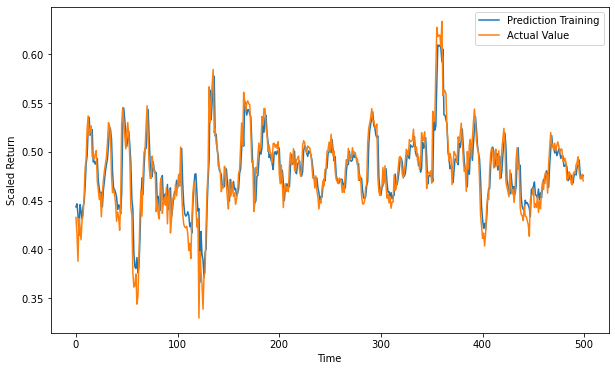

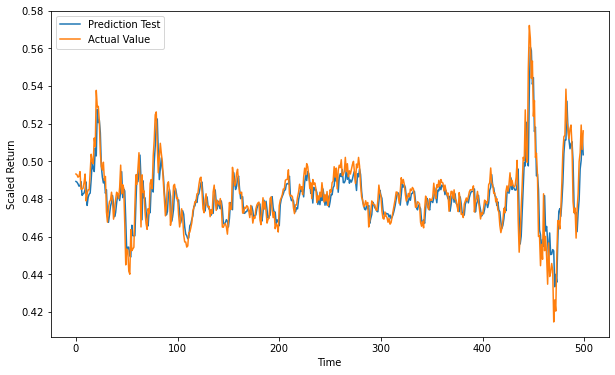


Average Train Error: 0.013823096266176081 
Average Test Error: 0.016122734569902968


In [31]:
# make predictions and evaluate model 
rmse_train_GRU, rmse_test_GRU, rmse_max_GRU = pred_eval(model_GRU, 'GRU')

In [32]:
# manually check for number of parameters and epochs needed 
no_params_GRU = 6441
epochs_GRU = 261 #manually 

# display results 
GRU_results = np.array(['{:}'.format(no_params_GRU), '{:}'.format(epochs_GRU), round(time_needed_GRU/60,2), 
                        '{:.3e}'.format(rmse_train_GRU), '{:.3e}'.format(rmse_test_GRU)])
GRU_results = GRU_results.reshape((1,5))
table_GRU = pd.DataFrame(GRU_results,index=['GRU'],
                         columns=['No. Parameters','No. Epochs','Time [m]','RMSE Train','RMSE Test'])
table_GRU

,No. Parameters,No. Epochs,Time [m],RMSE Train,RMSE Test
GRU,6441,261,54.48,1.382e-02,1.612e-02


## CNN

In [33]:
# build model 
model_CNN = CNN_()

# fit model 
time_needed_CNN, history_CNN = train_model(model_CNN,'CNN')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 32)           0         
 )                                                               
                                                                 
 dropout_7 (Dropout)         (None, 13, 32)            0         
                                                                 
 flatten (Flatten)           (None, 416)               0         
                                                                 
 dense_3 (Dense)             (None, 20)                8340      
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                      

Epoch 27/1000
130/134 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 00027: val_loss improved from 0.00025 to 0.00024, saving model to best_model_uniCNN.h5
134/134 [==============================] - 2s 13ms/step - loss: 0.0037 - val_loss: 2.4458e-04
Epoch 28/1000
131/134 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 00028: val_loss improved from 0.00024 to 0.00024, saving model to best_model_uniCNN.h5
134/134 [==============================] - 2s 13ms/step - loss: 0.0035 - val_loss: 2.3712e-04
Epoch 29/1000
131/134 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 00029: val_loss improved from 0.00024 to 0.00022, saving model to best_model_uniCNN.h5
134/134 [==============================] - 2s 13ms/step - loss: 0.0031 - val_loss: 2.1925e-04
Epoch 30/1000
130/134 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 00030: val_loss did not improve from 0.00022
134/134 [==============================] - 2s 12ms/step - loss: 0.00

Epoch 60/1000
131/134 [============================>.] - ETA: 0s - loss: 3.1338e-04
Epoch 00060: val_loss improved from 0.00015 to 0.00015, saving model to best_model_uniCNN.h5
134/134 [==============================] - 2s 14ms/step - loss: 3.0988e-04 - val_loss: 1.4544e-04
Epoch 61/1000
132/134 [============================>.] - ETA: 0s - loss: 3.0934e-04
Epoch 00061: val_loss did not improve from 0.00015
134/134 [==============================] - 2s 13ms/step - loss: 3.0727e-04 - val_loss: 1.4889e-04
Epoch 62/1000
131/134 [============================>.] - ETA: 0s - loss: 3.0721e-04
Epoch 00062: val_loss did not improve from 0.00015
134/134 [==============================] - 2s 13ms/step - loss: 3.0386e-04 - val_loss: 1.4621e-04
Epoch 63/1000
132/134 [============================>.] - ETA: 0s - loss: 2.9743e-04
Epoch 00063: val_loss improved from 0.00015 to 0.00014, saving model to best_model_uniCNN.h5
134/134 [==============================] - 2s 13ms/step - loss: 2.9541e-04 - val_l

Epoch 94/1000
129/134 [===========================>..] - ETA: 0s - loss: 2.4858e-04
Epoch 00094: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 14ms/step - loss: 2.4474e-04 - val_loss: 1.3528e-04
Epoch 95/1000
130/134 [============================>.] - ETA: 0s - loss: 2.4581e-04
Epoch 00095: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 15ms/step - loss: 2.4364e-04 - val_loss: 1.3291e-04
Epoch 96/1000
132/134 [============================>.] - ETA: 0s - loss: 2.4586e-04
Epoch 00096: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 13ms/step - loss: 2.4419e-04 - val_loss: 1.3023e-04
Epoch 97/1000
131/134 [============================>.] - ETA: 0s - loss: 2.4622e-04
Epoch 00097: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 13ms/step - loss: 2.4330e-04 - val_loss: 1.2896e-04
Epoch 98/1000
130/134 [============================>.] - ETA: 0s - l

Epoch 129/1000
132/134 [============================>.] - ETA: 0s - loss: 2.0790e-04
Epoch 00129: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 12ms/step - loss: 2.0647e-04 - val_loss: 1.2684e-04
Epoch 130/1000
132/134 [============================>.] - ETA: 0s - loss: 2.1340e-04
Epoch 00130: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 14ms/step - loss: 2.1201e-04 - val_loss: 1.2792e-04
Epoch 131/1000
132/134 [============================>.] - ETA: 0s - loss: 2.1249e-04
Epoch 00131: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 15ms/step - loss: 2.1105e-04 - val_loss: 1.2593e-04
Epoch 132/1000
134/134 [==============================] - ETA: 0s - loss: 2.0938e-04
Epoch 00132: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 13ms/step - loss: 2.0938e-04 - val_loss: 1.2582e-04
Epoch 133/1000
129/134 [===========================>..] - ETA: 0

Epoch 164/1000
132/134 [============================>.] - ETA: 0s - loss: 1.9908e-04
Epoch 00164: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 17ms/step - loss: 1.9773e-04 - val_loss: 1.2646e-04
Epoch 165/1000
132/134 [============================>.] - ETA: 0s - loss: 2.0177e-04
Epoch 00165: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 14ms/step - loss: 2.0040e-04 - val_loss: 1.1990e-04
Epoch 166/1000
130/134 [============================>.] - ETA: 0s - loss: 1.9898e-04
Epoch 00166: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 13ms/step - loss: 1.9694e-04 - val_loss: 1.2466e-04
Epoch 167/1000
133/134 [============================>.] - ETA: 0s - loss: 1.9933e-04
Epoch 00167: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 13ms/step - loss: 1.9899e-04 - val_loss: 1.2067e-04
Epoch 168/1000
133/134 [============================>.] - ETA: 0

131/134 [============================>.] - ETA: 0s - loss: 1.9306e-04
Epoch 00199: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 13ms/step - loss: 1.9089e-04 - val_loss: 1.1991e-04
Epoch 200/1000
131/134 [============================>.] - ETA: 0s - loss: 1.9259e-04
Epoch 00200: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 14ms/step - loss: 1.9044e-04 - val_loss: 1.2270e-04
Epoch 201/1000
131/134 [============================>.] - ETA: 0s - loss: 1.9614e-04
Epoch 00201: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 14ms/step - loss: 1.9399e-04 - val_loss: 1.2147e-04
Epoch 202/1000
132/134 [============================>.] - ETA: 0s - loss: 1.9141e-04
Epoch 00202: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 16ms/step - loss: 1.9012e-04 - val_loss: 1.2465e-04
Epoch 203/1000
130/134 [============================>.] - ETA: 0s - loss: 1.901

Epoch 234/1000
131/134 [============================>.] - ETA: 0s - loss: 1.8809e-04
Epoch 00234: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 15ms/step - loss: 1.8603e-04 - val_loss: 1.1917e-04
Epoch 235/1000
130/134 [============================>.] - ETA: 0s - loss: 1.8973e-04
Epoch 00235: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 15ms/step - loss: 1.8785e-04 - val_loss: 1.2202e-04
Epoch 236/1000
131/134 [============================>.] - ETA: 0s - loss: 1.9188e-04
Epoch 00236: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 14ms/step - loss: 1.8977e-04 - val_loss: 1.2048e-04
Epoch 237/1000
129/134 [===========================>..] - ETA: 0s - loss: 1.8741e-04
Epoch 00237: val_loss did not improve from 0.00012
134/134 [==============================] - 2s 13ms/step - loss: 1.8511e-04 - val_loss: 1.2020e-04
Epoch 238/1000
133/134 [============================>.] - ETA: 0

Epoch 269/1000
131/134 [============================>.] - ETA: 0s - loss: 1.8765e-04- ETA: 0s
Epoch 00269: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 16ms/step - loss: 1.8565e-04 - val_loss: 1.1732e-04
Epoch 270/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8046e-04
Epoch 00270: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 16ms/step - loss: 1.8014e-04 - val_loss: 1.2302e-04
Epoch 271/1000
134/134 [==============================] - ETA: 0s - loss: 1.8130e-04
Epoch 00271: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 15ms/step - loss: 1.8130e-04 - val_loss: 1.1862e-04
Epoch 272/1000
134/134 [==============================] - ETA: 0s - loss: 1.8312e-04
Epoch 00272: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 13ms/step - loss: 1.8312e-04 - val_loss: 1.2369e-04
Epoch 273/1000
131/134 [============================>.]

Epoch 304/1000
132/134 [============================>.] - ETA: 0s - loss: 1.8095e-04
Epoch 00304: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 12ms/step - loss: 1.7978e-04 - val_loss: 1.2014e-04
Epoch 305/1000
131/134 [============================>.] - ETA: 0s - loss: 1.8549e-04
Epoch 00305: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 12ms/step - loss: 1.8344e-04 - val_loss: 1.2089e-04
Epoch 306/1000
131/134 [============================>.] - ETA: 0s - loss: 1.8091e-04
Epoch 00306: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 12ms/step - loss: 1.7892e-04 - val_loss: 1.2241e-04
Epoch 307/1000
131/134 [============================>.] - ETA: 0s - loss: 1.8253e-04
Epoch 00307: val_loss improved from 0.00011 to 0.00011, saving model to best_model_uniCNN.h5
134/134 [==============================] - 2s 13ms/step - loss: 1.8058e-04 - val_loss: 1.1354e-04
Epoch 308/1000
131/134

Epoch 339/1000
129/134 [===========================>..] - ETA: 0s - loss: 1.7871e-04
Epoch 00339: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 14ms/step - loss: 1.7612e-04 - val_loss: 1.1893e-04
Epoch 340/1000
131/134 [============================>.] - ETA: 0s - loss: 1.8120e-04
Epoch 00340: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 12ms/step - loss: 1.7927e-04 - val_loss: 1.2241e-04
Epoch 341/1000
130/134 [============================>.] - ETA: 0s - loss: 1.7948e-04
Epoch 00341: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 12ms/step - loss: 1.7776e-04 - val_loss: 1.1987e-04
Epoch 342/1000
132/134 [============================>.] - ETA: 0s - loss: 1.8291e-04
Epoch 00342: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 12ms/step - loss: 1.8174e-04 - val_loss: 1.1884e-04
Epoch 343/1000
131/134 [============================>.] - ETA: 0

131/134 [============================>.] - ETA: 0s - loss: 1.8219e-04
Epoch 00374: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 13ms/step - loss: 1.8013e-04 - val_loss: 1.2157e-04
Epoch 375/1000
129/134 [===========================>..] - ETA: 0s - loss: 1.8234e-04
Epoch 00375: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 13ms/step - loss: 1.8001e-04 - val_loss: 1.1536e-04
Epoch 376/1000
134/134 [==============================] - ETA: 0s - loss: 1.8370e-04
Epoch 00376: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 15ms/step - loss: 1.8370e-04 - val_loss: 1.2072e-04
Epoch 377/1000
133/134 [============================>.] - ETA: 0s - loss: 1.8095e-04- ETA: 0s - 
Epoch 00377: val_loss did not improve from 0.00011
134/134 [==============================] - 2s 15ms/step - loss: 1.8063e-04 - val_loss: 1.1910e-04
Epoch 378/1000
132/134 [============================>.] - ETA: 0s -

459/459 [==============================] - 1s 1ms/step

Results for AAPL :
Train Error: 0.012110470644622761 Test Error: 0.014552842003779678


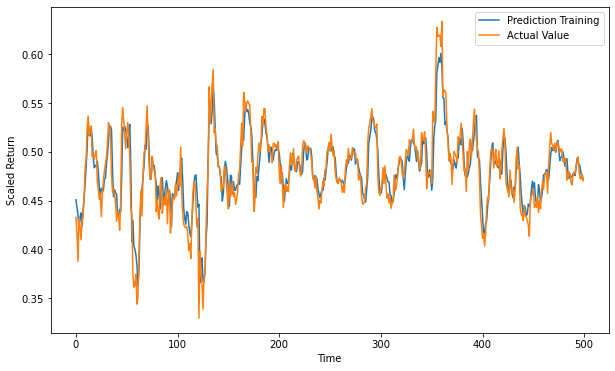

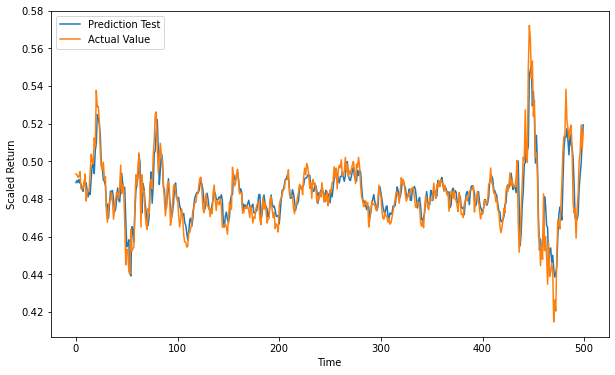


Average Train Error: 0.012110470644622761 
Average Test Error: 0.014552842003779678


In [34]:
# make predictions and evaluate model 
rmse_train_CNN, rmse_test_CNN, rmse_max_CNN = pred_eval(model_CNN, 'CNN')

In [35]:
# manually check for number of parameters and epochs needed 
no_params_CNN = 8973
epochs_CNN = 407 #manually 

# display results 
CNN_results = np.array(['{:}'.format(no_params_CNN), '{:}'.format(epochs_CNN), round(time_needed_CNN/60,2), 
                        '{:.3e}'.format(rmse_train_CNN), '{:.3e}'.format(rmse_test_CNN)])
CNN_results = CNN_results.reshape((1,5))
table_CNN = pd.DataFrame(CNN_results,index=['CNN'],
                         columns=['No. Parameters','No. Epochs','Time [m]','RMSE Train','RMSE Test'])
table_CNN

,No. Parameters,No. Epochs,Time [m],RMSE Train,RMSE Test
CNN,8973,407,12.36,1.211e-02,1.455e-02


## CNN mit Dilation

In [36]:
# build model 
model_DilCNN = DilCNN_()

# fit model 
time_needed_DilCNN, history_DilCNN = train_model(model_DilCNN,'DilCNN')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 22, 32)            192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 11, 32)            0         
                                                                 
 flatten_1 (Flatten)         (None, 352)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                7060      
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                      

Epoch 27/1000
131/134 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 00027: val_loss did not improve from 0.00044
134/134 [==============================] - 2s 19ms/step - loss: 0.0045 - val_loss: 4.6014e-04
Epoch 28/1000
131/134 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00028: val_loss improved from 0.00044 to 0.00044, saving model to best_model_uniDilCNN.h5
134/134 [==============================] - 2s 15ms/step - loss: 0.0041 - val_loss: 4.3545e-04
Epoch 29/1000
132/134 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 00029: val_loss improved from 0.00044 to 0.00038, saving model to best_model_uniDilCNN.h5
134/134 [==============================] - 2s 16ms/step - loss: 0.0038 - val_loss: 3.7658e-04
Epoch 30/1000
132/134 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 00030: val_loss improved from 0.00038 to 0.00037, saving model to best_model_uniDilCNN.h5
134/134 [==============================] - 2s 16ms/step - l

Epoch 59/1000
131/134 [============================>.] - ETA: 0s - loss: 3.1255e-04
Epoch 00059: val_loss improved from 0.00016 to 0.00016, saving model to best_model_uniDilCNN.h5
134/134 [==============================] - 2s 15ms/step - loss: 3.0943e-04 - val_loss: 1.5938e-04
Epoch 60/1000
131/134 [============================>.] - ETA: 0s - loss: 3.0832e-04
Epoch 00060: val_loss did not improve from 0.00016
134/134 [==============================] - 2s 14ms/step - loss: 3.0510e-04 - val_loss: 1.6129e-04
Epoch 61/1000
134/134 [==============================] - ETA: 0s - loss: 3.0260e-04
Epoch 00061: val_loss did not improve from 0.00016
134/134 [==============================] - 2s 14ms/step - loss: 3.0260e-04 - val_loss: 1.6197e-04
Epoch 62/1000
133/134 [============================>.] - ETA: 0s - loss: 3.0703e-04
Epoch 00062: val_loss did not improve from 0.00016
134/134 [==============================] - 2s 13ms/step - loss: 3.0654e-04 - val_loss: 1.6001e-04
Epoch 63/1000
132/134 [

132/134 [============================>.] - ETA: 0s - loss: 2.3735e-04
Epoch 00093: val_loss did not improve from 0.00015
134/134 [==============================] - 2s 14ms/step - loss: 2.3579e-04 - val_loss: 1.5512e-04
Epoch 94/1000
133/134 [============================>.] - ETA: 0s - loss: 2.3680e-04
Epoch 00094: val_loss did not improve from 0.00015
134/134 [==============================] - 2s 16ms/step - loss: 2.3640e-04 - val_loss: 1.5348e-04
Epoch 95/1000
131/134 [============================>.] - ETA: 0s - loss: 2.4203e-04
Epoch 00095: val_loss improved from 0.00015 to 0.00015, saving model to best_model_uniDilCNN.h5
134/134 [==============================] - 2s 15ms/step - loss: 2.3931e-04 - val_loss: 1.4860e-04
Epoch 96/1000
131/134 [============================>.] - ETA: 0s - loss: 2.3733e-04
Epoch 00096: val_loss improved from 0.00015 to 0.00015, saving model to best_model_uniDilCNN.h5
134/134 [==============================] - 2s 16ms/step - loss: 2.3466e-04 - val_loss: 1.4

Epoch 127/1000
131/134 [============================>.] - ETA: 0s - loss: 2.2045e-04
Epoch 00127: val_loss did not improve from 0.00014
134/134 [==============================] - 2s 14ms/step - loss: 2.1792e-04 - val_loss: 1.4264e-04
Epoch 128/1000
131/134 [============================>.] - ETA: 0s - loss: 2.2241e-04
Epoch 00128: val_loss did not improve from 0.00014
134/134 [==============================] - 2s 13ms/step - loss: 2.1993e-04 - val_loss: 1.4171e-04
Epoch 129/1000
131/134 [============================>.] - ETA: 0s - loss: 2.1974e-04
Epoch 00129: val_loss did not improve from 0.00014
134/134 [==============================] - 2s 13ms/step - loss: 2.1729e-04 - val_loss: 1.4882e-04
Epoch 130/1000
131/134 [============================>.] - ETA: 0s - loss: 2.2132e-04
Epoch 00130: val_loss did not improve from 0.00014
134/134 [==============================] - 2s 13ms/step - loss: 2.1880e-04 - val_loss: 1.4627e-04
Epoch 131/1000
132/134 [============================>.] - ETA: 0

133/134 [============================>.] - ETA: 0s - loss: 2.1056e-04
Epoch 00161: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 17ms/step - loss: 2.1016e-04 - val_loss: 1.3712e-04
Epoch 162/1000
131/134 [============================>.] - ETA: 0s - loss: 2.0756e-04
Epoch 00162: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 15ms/step - loss: 2.0532e-04 - val_loss: 1.4009e-04
Epoch 163/1000
130/134 [============================>.] - ETA: 0s - loss: 2.1511e-04
Epoch 00163: val_loss improved from 0.00013 to 0.00013, saving model to best_model_uniDilCNN.h5
134/134 [==============================] - 2s 13ms/step - loss: 2.1283e-04 - val_loss: 1.3209e-04
Epoch 164/1000
131/134 [============================>.] - ETA: 0s - loss: 2.0680e-04
Epoch 00164: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 13ms/step - loss: 2.0461e-04 - val_loss: 1.3349e-04
Epoch 165/1000
132/134 [==========

Epoch 196/1000
133/134 [============================>.] - ETA: 0s - loss: 2.0308e-04
Epoch 00196: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 14ms/step - loss: 2.0275e-04 - val_loss: 1.3273e-04
Epoch 197/1000
131/134 [============================>.] - ETA: 0s - loss: 2.0641e-04
Epoch 00197: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 14ms/step - loss: 2.0405e-04 - val_loss: 1.3558e-04
Epoch 198/1000
134/134 [==============================] - ETA: 0s - loss: 2.0154e-04
Epoch 00198: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 14ms/step - loss: 2.0154e-04 - val_loss: 1.4051e-04
Epoch 199/1000
131/134 [============================>.] - ETA: 0s - loss: 2.0784e-04
Epoch 00199: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 13ms/step - loss: 2.0553e-04 - val_loss: 1.3622e-04
Epoch 200/1000
132/134 [============================>.] - ETA: 0

133/134 [============================>.] - ETA: 0s - loss: 1.9747e-04
Epoch 00231: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 14ms/step - loss: 1.9711e-04 - val_loss: 1.3596e-04
Epoch 232/1000
132/134 [============================>.] - ETA: 0s - loss: 2.0094e-04
Epoch 00232: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 14ms/step - loss: 1.9953e-04 - val_loss: 1.4255e-04
Epoch 233/1000
132/134 [============================>.] - ETA: 0s - loss: 2.0377e-04
Epoch 00233: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 13ms/step - loss: 2.0242e-04 - val_loss: 1.3624e-04
Epoch 234/1000
129/134 [===========================>..] - ETA: 0s - loss: 2.0499e-04
Epoch 00234: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 14ms/step - loss: 2.0207e-04 - val_loss: 1.3091e-04
Epoch 235/1000
131/134 [============================>.] - ETA: 0s - loss: 1.969

130/134 [============================>.] - ETA: 0s - loss: 1.9997e-04
Epoch 00266: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 14ms/step - loss: 1.9816e-04 - val_loss: 1.3489e-04
Epoch 267/1000
133/134 [============================>.] - ETA: 0s - loss: 1.9546e-04
Epoch 00267: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 13ms/step - loss: 1.9515e-04 - val_loss: 1.3859e-04
Epoch 268/1000
134/134 [==============================] - ETA: 0s - loss: 1.9551e-04
Epoch 00268: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 14ms/step - loss: 1.9551e-04 - val_loss: 1.3917e-04
Epoch 269/1000
133/134 [============================>.] - ETA: 0s - loss: 1.9995e-04
Epoch 00269: val_loss did not improve from 0.00013
134/134 [==============================] - 2s 15ms/step - loss: 1.9959e-04 - val_loss: 1.4131e-04
Epoch 270/1000
133/134 [============================>.] - ETA: 0s - loss: 1.941

459/459 [==============================] - 1s 1ms/step

Results for AAPL :
Train Error: 0.013098947930504066 Test Error: 0.015417612970425114


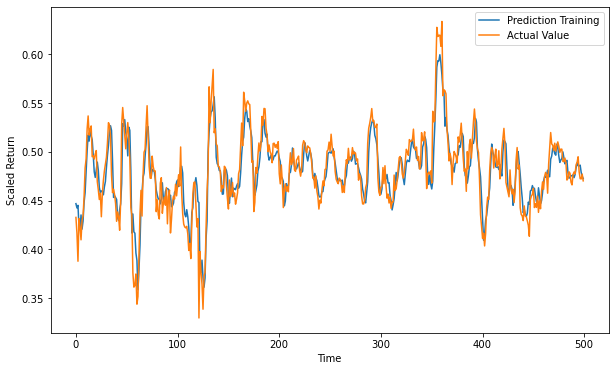

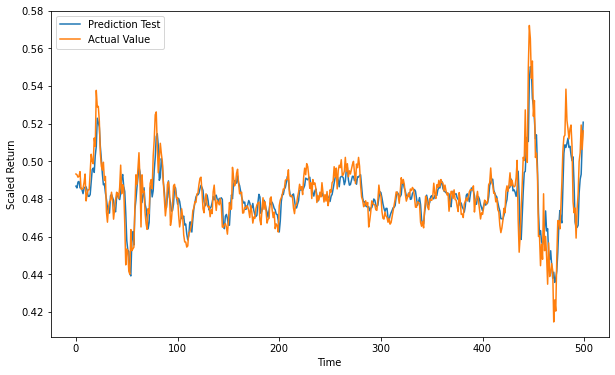


Average Train Error: 0.013098947930504066 
Average Test Error: 0.015417612970425114


In [37]:
# make predictions and evaluate model 
rmse_train_DilCNN, rmse_test_DilCNN, rmse_max_DilCNN = pred_eval(model_DilCNN, 'DilCNN')

In [38]:
# manually check for number of parameters and epochs needed 
no_params_DilCNN = 7693
epochs_DilCNN = 274 #manually 

# display results 
DilCNN_results = np.array(['{:}'.format(no_params_DilCNN), '{:}'.format(epochs_DilCNN), round(time_needed_DilCNN/60,2), 
                        '{:.3e}'.format(rmse_train_DilCNN), '{:.3e}'.format(rmse_test_DilCNN)])
DilCNN_results = DilCNN_results.reshape((1,5))
table_DilCNN = pd.DataFrame(DilCNN_results,index=['CNN+Dilation'],
                         columns=['No. Parameters','No. Epochs','Time [m]','RMSE Train','RMSE Test'])
table_DilCNN

,No. Parameters,No. Epochs,Time [m],RMSE Train,RMSE Test
CNN+Dilation,7693,274,9.1,1.310e-02,1.542e-02


## Results from Multivariate Training

In [39]:
# display results 
Multi_results = np.array(['{:}'.format(18509), '{:}'.format(915), 95.50, 
                        '{:.3e}'.format(0.01437), '{:.3e}'.format(0.01705)])
Multi_results = Multi_results.reshape((1,5))
table_Multi = pd.DataFrame(Multi_results,index=['Multivariate - Best'],
                         columns=['No. Parameters','No. Epochs','Time [m]','RMSE Train','RMSE Test'])
table_Multi

,No. Parameters,No. Epochs,Time [m],RMSE Train,RMSE Test
Multivariate - Best,18509,915,95.5,1.437e-02,1.705e-02


## Results - Overview

In [40]:
table_res = pd.concat((table_Multi, table_aRNN, table_LSTM, table_GRU,
                       table_CNN, table_DilCNN),
                      axis=0) 

table_res

,No. Parameters,No. Epochs,Time [m],RMSE Train,RMSE Test
Multivariate - Best,18509,915,95.5,1.437e-02,1.705e-02
Alpha RNN,2652,376,24.89,1.148e-02,1.345e-02
LSTM,8341,602,149.81,1.744e-02,2.024e-02
GRU,6441,261,54.48,1.382e-02,1.612e-02
CNN,8973,407,12.36,1.211e-02,1.455e-02
CNN+Dilation,7693,274,9.1,1.310e-02,1.542e-02


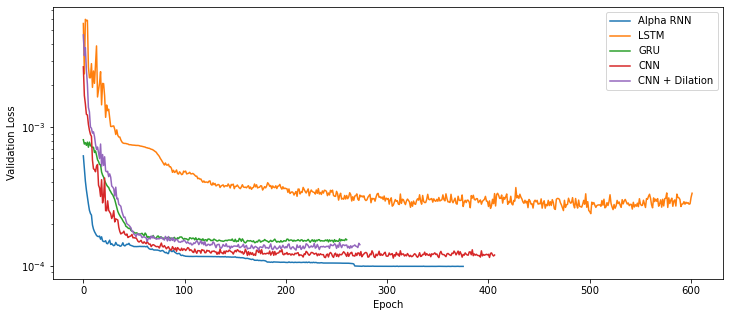

In [42]:
# plot histories and compare
fig = plt.figure(figsize=(12,5))
plt.plot(history_aRNN,label='Alpha RNN')
plt.plot(history_LSTM,label='LSTM')
plt.plot(history_GRU,label='GRU')
plt.plot(history_CNN,label='CNN')
plt.plot(history_DilCNN,label='CNN + Dilation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.yscale('log')
             
#string = 'C:/Users/morit/Documents/Studium/Master-Arbeit 2021/Master Thesis TeX/figures/Comp_Uni_Hist1.pdf'
#plt.savefig(string)
plt.show()